# Biology and Temperature Normalization

# Import Packages

In [11]:
%cd '/Users/akbaskind/Documents/Python Scripts/phyto'
%run PLT.py

from matplotlib import pyplot as plt
from matplotlib.dates import DateFormatter
import numpy as np
import xarray as xr
import pandas as pd
import scipy
from datetime import datetime, timedelta
import time
import seaborn
import matplotlib.dates as mdates
import bottleneck as bn
import PyCO2SYS as pyco2
import gsw
import math
import netCDF4 as nc
import requests
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

from importlib import reload
import warnings
warnings.filterwarnings('ignore')

/Users/akbaskind/Documents/Python Scripts/phyto


# Pull data from [spreadsheet](https://docs.google.com/spreadsheets/d/1uLRAvFDsTSfS-c45DiG-W6VMa8I1J7XD1O-pJA4fp10/edit#gid=0)

- opening all the datasets in the spreadsheet all at once
- `hydrocat620`
- `hydrocat720`
- `MV`
- `QP`

In [2]:
#The scope is always look like this so we did not need to change anything

import gspread
from df2gspread import df2gspread as d2g
from oauth2client.service_account import ServiceAccountCredentials

scope = [
   'https://spreadsheets.google.com/feeds',
         'https://www.googleapis.com/auth/drive']

# Name of our Service Account Key
google_key_file = 'servicecredentials.json'
credentials = ServiceAccountCredentials.from_json_keyfile_name(google_key_file, scope)
gc = gspread.authorize(credentials)

# Spreadsheet key
spreadsheet_key = '1uLRAvFDsTSfS-c45DiG-W6VMa8I1J7XD1O-pJA4fp10'

# Worksheet keys
wks_hydrocat620 = 'Hydrocat 620'
wks_hydrocat720 = 'Hydrocat 720'
wks_MV = 'MV'
wks_QP = 'QP'

#Opening the worksheet by using Worksheet ID
workbook = gc.open_by_key(spreadsheet_key)

## HYDROCAT 620
#Selecting which sheet to pulling the data
sheet = workbook.worksheet(wks_hydrocat620)
values = sheet.get_all_values()
hydrocat620 = pd.DataFrame(values[1:], columns = values[0])


## HYDROCAT 720
#Selecting which sheet to pulling the data
sheet = workbook.worksheet(wks_hydrocat720)
values = sheet.get_all_values()
hydrocat720 = pd.DataFrame(values[1:], columns = values[0])

## MV
#Selecting which sheet to pulling the data
sheet = workbook.worksheet(wks_MV)
values = sheet.get_all_values()
MV = pd.DataFrame(values[1:], columns = values[0])

## QP
#Selecting which sheet to pulling the data
sheet = workbook.worksheet(wks_QP)
values = sheet.get_all_values()
QP = pd.DataFrame(values[1:], columns = values[0])

## Correct data types

In [3]:
for k in hydrocat620.keys():
    if k == 'DateTime' or k == 'time':
        hydrocat620[k] = pd.to_datetime(hydrocat620[k])
    else:
        hydrocat620[k] = pd.to_numeric(hydrocat620[k])

for k in hydrocat720.keys():
    if k == 'DateTime' or k == 'time':
        hydrocat720[k] = pd.to_datetime(hydrocat720[k])
    else:
        hydrocat720[k] = pd.to_numeric(hydrocat720[k])
        
for k in QP.keys():
    if k == 'DateTime' or k == 'time':
        QP[k] = pd.to_datetime(QP[k])
    else:
        QP[k] = pd.to_numeric(QP[k])
        
for k in MV.keys():
    if k == 'DateTime' or k == 'time':
        MV[k] = pd.to_datetime(MV[k])
    else:
        MV[k] = pd.to_numeric(MV[k])

# Remove effect of biology

Pimenta, A., Oczkowski, A., McKinney, R., & Grear, J., 2023. [Geographical and seasonal patterns in the
carbonate chemistry of Narragansett Bay, RI](https://www.sciencedirect.com/science/article/pii/S2352485523000920), *Regional Studies in Marine Science*, **62**, 102903. 

## Step 1. Get alkalinity

Since we do not have alkalinity from our sensors, we can estimate alkalinity using salinity. Pimenta et al. (2023) provides this relationship for estimating alkalinity [µmol/kg] from salinity [PSU] in estuaries:

$$ 477.62 + 51.99 \times S = TA $$

In [6]:
hydrocat720['Alkalinity'] = 477.62 + 51.99 * hydrocat720['hydrocatSalinity']

## Step 2. Calculate actual DIC

We can use PyCO2SYS to calculate DIC. Remember, to solve the marine carbonate system we need any combination of 2 of the following:

1. Total alkalinity (type `1`) in μmol·kg−1.
2. Dissolved inorganic carbon (type `2`) in μmol·kg−1.
3. pH (type `3`) on the Total, Seawater, Free or NBS scale1. Which scale is given by the argument opt_pH_scale.
4. Any one of:Partial pressure of CO2 (type `4`) in μatm, Fugacity of CO2 (type `5`) in μatm, Aqueous CO2 (type `8`) in μmol·kg−1, or Dry mole fraction of CO2 (type `9`) in ppm.
5. Any one of: Carbonate ion (type `6`) in μmol·kg−1, Saturation state w.r.t. calcite (type `10`), or Saturation state w.r.t. aragonite (type `11`).

We have pH adjusted to temperature and total alkalinity.

We also need to provide certain hydrographic conditions, specifically temperature and salinity.

Thus, the function will take the following form

```python
results = pyco2.sys(par1 = TA, par2 = pH, par1_type = 1, par2_type = 3, temperature = T, salinity = S)
```

`results` is a dictionary containing arrays of all kinds of parameters. We are interested in `dic`.

In [40]:
TA = hydrocat720['Alkalinity']
pH = hydrocat720['adjusted_ph temp']
T = hydrocat720['hydrocatTemperature']
S = hydrocat720['hydrocatSalinity']

results = pyco2.sys(par1 = TA, par2 = pH, par1_type = 1, par2_type = 3, temperature = T, salinity = S)

In [41]:
hydrocat720['DIC_measured'] = results['dic']

## Step 3. Calculate theoretical DIC produced through biology
### Conceptual Overview
#### Oxidation/remineralization of organic matter
The following reaction describes the respiration and photosynthesis of organic matter (Sarmiento & Gruber, 2006). 
$$\require{mhchem}$$   
$$\ce{OM + 150 O2 <=> 106 CO2 + 16 HNO3 + H3PO4 + 78 H2O}$$

#### Redfield Ratio
From this reaction, we arrive at the Redfield ratio: $106 C: 16 N: 1 P: 150 O_2$. We can rewrite this ratio in terms of DIC and TA as follows: $106\ \text{DIC}: -17\ \text{TA}: 150\ \text{O}_2$

*This is an explanation I wrote in a homework assigment for why the Redfield ratio in terms of DIC and TA is what it is.* The reaction produces 106 moles of carbon for every 150 moles of oxygen consumed (i.e. cell respiration), or it consumes 106 moles of carbon for every 150 moles of oxygen produced (i.e. photosynthesis). Further, the respiration of organic matter produces 16 moles of NO$_3^-$ and 1 mole of HPO$_4^{2-}$. Alkalinity under one definition is the ability of a solution to react with additional H$^+$. Generally, the charge of an anion is equal to the number of protons it will accept, except in the case of HPO$_4^{2-}$. HPO$_4^{2-}$ only accepts 1 proton to become H$_2$PO$_4^{-}$. Thus, 1 mole of NO$_3^-$ and 1 mole of HPO$_4^{2-}$ will each accept 1 mole of protons. Since we have 16 moles of NO$_3^-$, we multiply to get 16 moles of protons. In total, the products of aerobic respiration can accept 17 moles of H$^+$. This increases the free hydrogens in the solution and thus decreases alkalinity by 17 moles (or mole equivalents). 

#### AOU
AOU, or apparent oxygen utilization, is the difference between oxygen saturation and measured oxygen. The oxygen saturation concentration is the maximum amount of oxygen soluble a water parcel with a given temperature and given salinity. Though salinity does influence solubility, solubility is dominated by temperature.

$$\text{AOU}=[O_{2}]_{\text{saturation}}-[O_{2}]_{\text{observed}}$$

Biology is the primary sink for oxygen in the ocean, so this difference in oxygen, the AOU, is often understood to be the amount of oxygen consumed by biology. Thus, we can use AOU with the Redfield ratio to determine how much DIC is produced based on how much oxygen is consumed. 

I wrote a function that calculates saturation oxygen: `PLT.o2sat(S,T)`. It outputs oxygen saturation concentration in umol/L. *Note that most of our sensors provide dissolved oxygen in umol/kg so we need to convert units.*

#### Overview
To summarize, we can calculate the theoretical DIC produced from biology alone using AOU and the Redfield ratio as follows:

$$ \text{DIC}_{\text{theoretical}} = \text{AOU} \times \frac{106 \ \text{C}}{150 \ \text{O}_2}$$


### Step 3a. Convert oxygen units

Since our `o2sat(S,T)` function has units of umol/L, let's convert our sensor DO to umol/L from umol/kg. 

$$ \frac{\text{umol}}{\text{L}} \times \frac{1000 \text{L}}{1 \text{m}^3} \times \frac{\text{m}^3}{\text{kg}}$$

As the above equation shows, we need to first calculate density. I have done this using `gsw.rho(S,T,P)` and set the pressure `P` to zero since this is the surface ocean. 

The conversion then ends up being DO times 1000 (since there are 1000 liters in a cubic meter) and divided by density.

In [42]:

hydrocat720['Density'] = gsw.rho(hydrocat720['hydrocatSalinity'].to_numpy(), 
                                 hydrocat720['hydrocatTemperature'].to_numpy(), 
                                 np.zeros(len(hydrocat720['hydrocatSalinity'])))
hydrocat720['DO [umol/L]'] = hydrocat720['hydrocatDissOxygen'] * 1000 / hydrocat720['Density']

We can see the slight difference in magnitudes in the dissolved oxygen with different units.

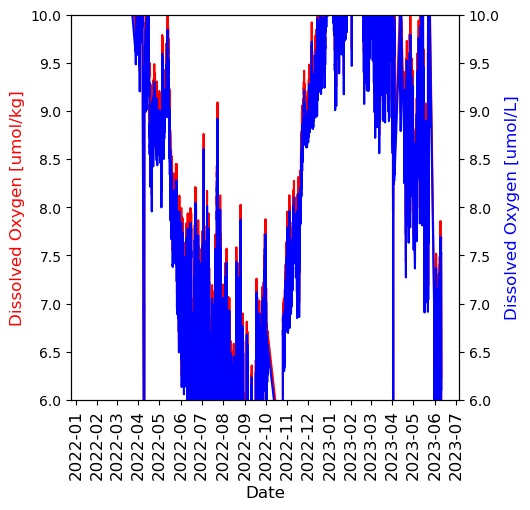

In [115]:
fig, ax = plt.subplots(figsize = [5,5])

ax.plot(hydrocat720["DateTime"],hydrocat720['hydrocatDissOxygen'],color="red")


# set x-axis label
ax.set_xlabel("Date", fontsize = 12)
# set y-axis label
ax.set_ylabel("Dissolved Oxygen [umol/kg]",color="red",fontsize=12)
ax.set_ylim([6,10])

# ax.legend(loc="upper left",fontsize = 40)

# twin object for two different y-axis on the sample plot
ax2=ax.twinx()

ax2.plot(hydrocat720["DateTime"], hydrocat720['DO [umol/L]'],color="blue")
ax2.set_ylabel("Dissolved Oxygen [umol/L]",color="blue",fontsize=12)
ax2.set_ylim([6,10])

ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.tick_params('x',labelsize = 12, labelrotation = 90)


### Step 3b. Calculate saturation oxygen concentration

In [44]:
hydrocat720['O2 sat'] = PLT.o2sat(hydrocat720['hydrocatSalinity'], hydrocat720['hydrocatTemperature'])

### Step 3c. Calculate AOU

$$\text{AOU}=[O_{2}]_{\text{saturation}}-[O_{2}]_{\text{observed}}$$

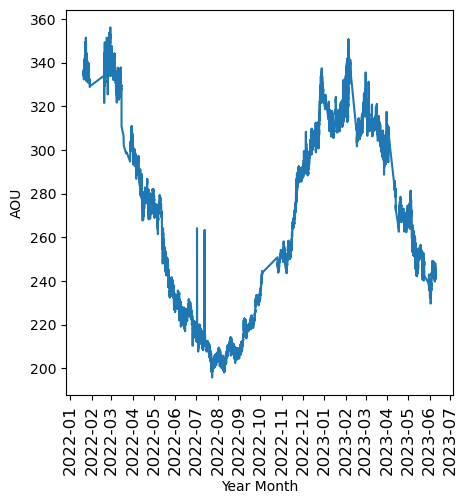

In [114]:
hydrocat720['AOU'] = hydrocat720['O2 sat'] - hydrocat720['DO [umol/L]']

fig, ax = plt.subplots(figsize = [5,5])
ax.plot(hydrocat720["DateTime"],hydrocat720['AOU'])
ax.set_xlabel('Year Month')
ax.set_ylabel('AOU')
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.tick_params('x',labelsize = 12, labelrotation = 90)

### Step 3d. Multiply AOU by the Redfield ratio to get theoretical DIC

In [46]:
C_to_O2 = 106/150

hydrocat720['DIC theoretical'] = hydrocat720['AOU'] * C_to_O2

## Step 4. Recalculate pH using Alkalinity and DIC theoretical

Since we want to remove the effect of biology, we will substract the DIC produced through respiration (DIC theoretical) from the measured DIC. We will use that new DIC (the difference between DIC theoretical and DIC measured) to calculate a new pH.

In [53]:
TA = hydrocat720['Alkalinity']
# DIC = hydrocat720['DIC theoretical']
DIC = hydrocat720['DIC_measured'] - hydrocat720['DIC theoretical']
T = hydrocat720['hydrocatTemperature']
S = hydrocat720['hydrocatSalinity']

results = pyco2.sys(par1 = TA, par2 = DIC, par1_type = 1, par2_type = 2, temperature = T, salinity = S)
hydrocat720['pH theoretical'] = results['pH']

In [54]:
hydrocat720[['AOU', 'adjusted_ph temp', 'Alkalinity', 'DIC theoretical',
       'DIC_measured', 'pH theoretical']]

,AOU,adjusted_ph temp,Alkalinity,DIC theoretical,DIC_measured,pH theoretical
0,335.591272,8.466929,2009.021843,237.151165,1756.791784,8.873639
1,335.321215,8.442756,2010.046046,236.960325,1768.892538,8.855463
2,335.204278,8.450796,2010.519155,236.877690,1765.341328,8.860923
3,335.168136,8.460270,2010.711518,236.852150,1760.925867,8.867678
4,335.187347,8.460629,2010.680324,236.865725,1760.749639,8.867980
...,...,...,...,...,...,...
35572,244.213353,7.784883,2016.186065,172.577436,1930.646186,8.226498
35573,243.533253,7.814661,2013.919301,172.096832,1919.078618,8.243570
35574,242.828070,7.834495,2014.408007,171.598503,1912.829844,8.253955
35575,242.666753,7.854425,2012.801516,171.484505,1904.927658,8.266330


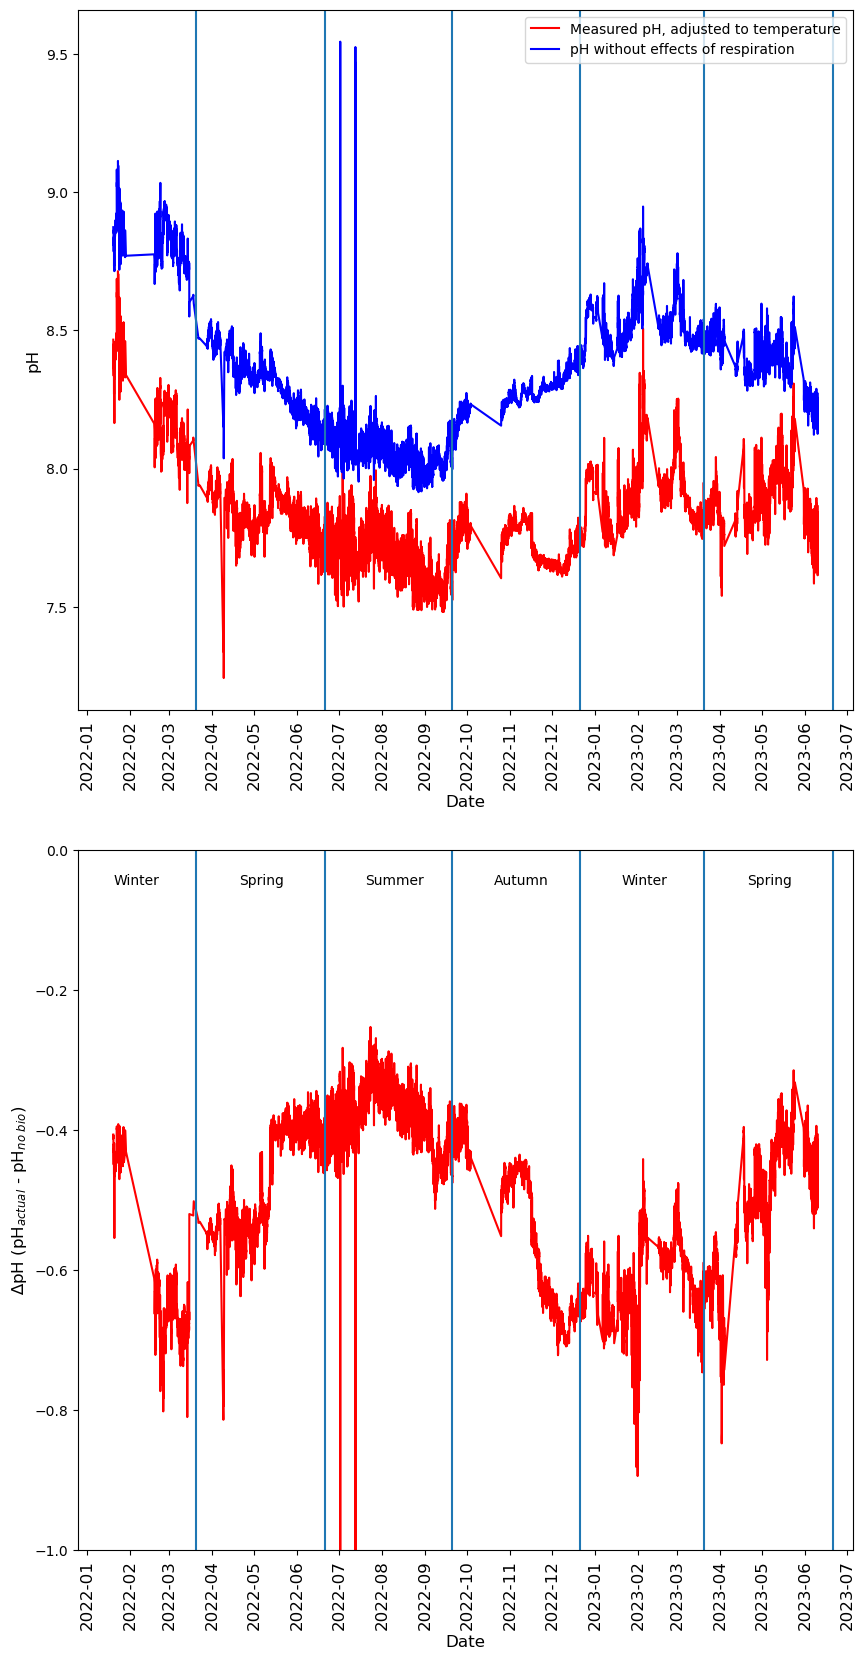

In [92]:
fig, ax = plt.subplots(nrows = 2, figsize = [10,20])

# First subplot: Plot both pH time series
ax[0].plot(hydrocat720["DateTime"],hydrocat720['adjusted_ph temp'],color="red", label = 'Measured pH, adjusted to temperature')
ax[0].plot(hydrocat720["DateTime"],hydrocat720['pH theoretical'],color="blue", label = 'pH without effects of respiration')

# set x-axis label
ax[0].set_xlabel("Date", fontsize = 12)
# set y-axis label
ax[0].set_ylabel("pH",fontsize=12)

ax[0].xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax[0].tick_params('x',labelsize = 12, labelrotation = 90)
ax[0].legend()

ax[0].axvline(datetime(2022, 3, 20))
ax[0].axvline(datetime(2022, 6, 21))
ax[0].axvline(datetime(2022, 9, 20))
ax[0].axvline(datetime(2022, 12, 21))
ax[0].axvline(datetime(2023, 3, 20))
ax[0].axvline(datetime(2023, 6, 21))

# Subplot 2: plot the difference in the pH
ax[1].plot(hydrocat720["DateTime"],hydrocat720['adjusted_ph temp'] - hydrocat720['pH theoretical'] ,color="red")
# set x-axis label
ax[1].set_xlabel("Date", fontsize = 12)
# set y-axis label
ax[1].set_ylabel("∆pH (pH$_{actual}$ - pH$_{no\ bio})$",fontsize=12)
ax[1].xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax[1].tick_params('x',labelsize = 12, labelrotation = 90)
ax[1].set_ylim([-1,0])

ax[1].text(datetime(2022, 1, 20), -0.05, 'Winter')
ax[1].axvline(datetime(2022, 3, 20))
ax[1].text(datetime(2022, 4, 20), -0.05, 'Spring')
ax[1].axvline(datetime(2022, 6, 21))
ax[1].text(datetime(2022, 7, 20), -0.05, 'Summer')
ax[1].axvline(datetime(2022, 9, 20))
ax[1].text(datetime(2022, 10, 20), -0.05, 'Autumn')
ax[1].axvline(datetime(2022, 12, 21))
ax[1].text(datetime(2023, 1, 20), -0.05, 'Winter')
ax[1].axvline(datetime(2023, 3, 20))
ax[1].text(datetime(2023, 4, 20), -0.05, 'Spring')
ax[1].axvline(datetime(2023, 6, 21))

## Observations of effect of biology
Overall, we see that biology (i.e. respiration) has a consistently negative effect on pH, meaning it consistently makes the water more acidic. This aligns with our understanding of respiration, which happens all year, increasing the DIC concentration in the water and, thus, increasing the acidity. 

We see that the effect of biology is *most* negative in the winter, when photosynthesis, in general, is decreased and thus far outpaced by respiration. However, we do see a less negative local excursion on the effect of biology on pH in the winter briefly, presumably when the bay has its typical wintertime phytoplankton bloom. During this period, photosynthesis will increase, decreasing DIC in the water and elevating the pH.

The effect of biology on pH weakens through the spring, as photosynthesis increases with light availablity. The effect of biology on pH is weakest in the summer. Without further information, we can explain this two ways. First, photosynthesis may be overcoming the effects of respiration. Second, biology overall may simply be less active and respiration overall may be decreased. Because we know Narragansett Bay is less alive in the summer, we might think the second possibility more likely.

# Remove effect of temperature
## Step 1. Find the annual mean temperature

Since we have more than 1 year of data here, we need to isolate 1 year.

In [94]:
start = datetime(2022, 1, 1)
end = datetime(2022, 12, 31)
H720_2022 = hydrocat720.where(hydrocat720['DateTime'] >= start).where(hydrocat720['DateTime'] <= end).dropna()
mean_temp = H720_2022['hydrocatTemperature'].mean()
mean_temp

15.481207442187456

## Step 2. Normalize to temperature using PyCO2SYS

Once again, we will use alkalinity and pH (temperature adjusted). This time we will use the keyword argument `temperature_out` to specify we want our results at a specific output temperature.

```python
results = pyco2.sys(par1 = TA, par2 = pH, par1_type = 1, par2_type = 3, temperature = T, salinity = S, temperature_out = mean_temp)
```

The output we want from results is `pH_out`.

In [104]:
TA = hydrocat720['Alkalinity']
pH = hydrocat720['adjusted_ph temp']
T = hydrocat720['hydrocatTemperature']
S = hydrocat720['hydrocatSalinity']

results = pyco2.sys(par1 = TA, par2 = pH, par1_type = 1, par2_type = 3, temperature = T, salinity = S, 
                    temperature_out = mean_temp)
hydrocat720['pH (temperature normalized)'] = results['pH_out']

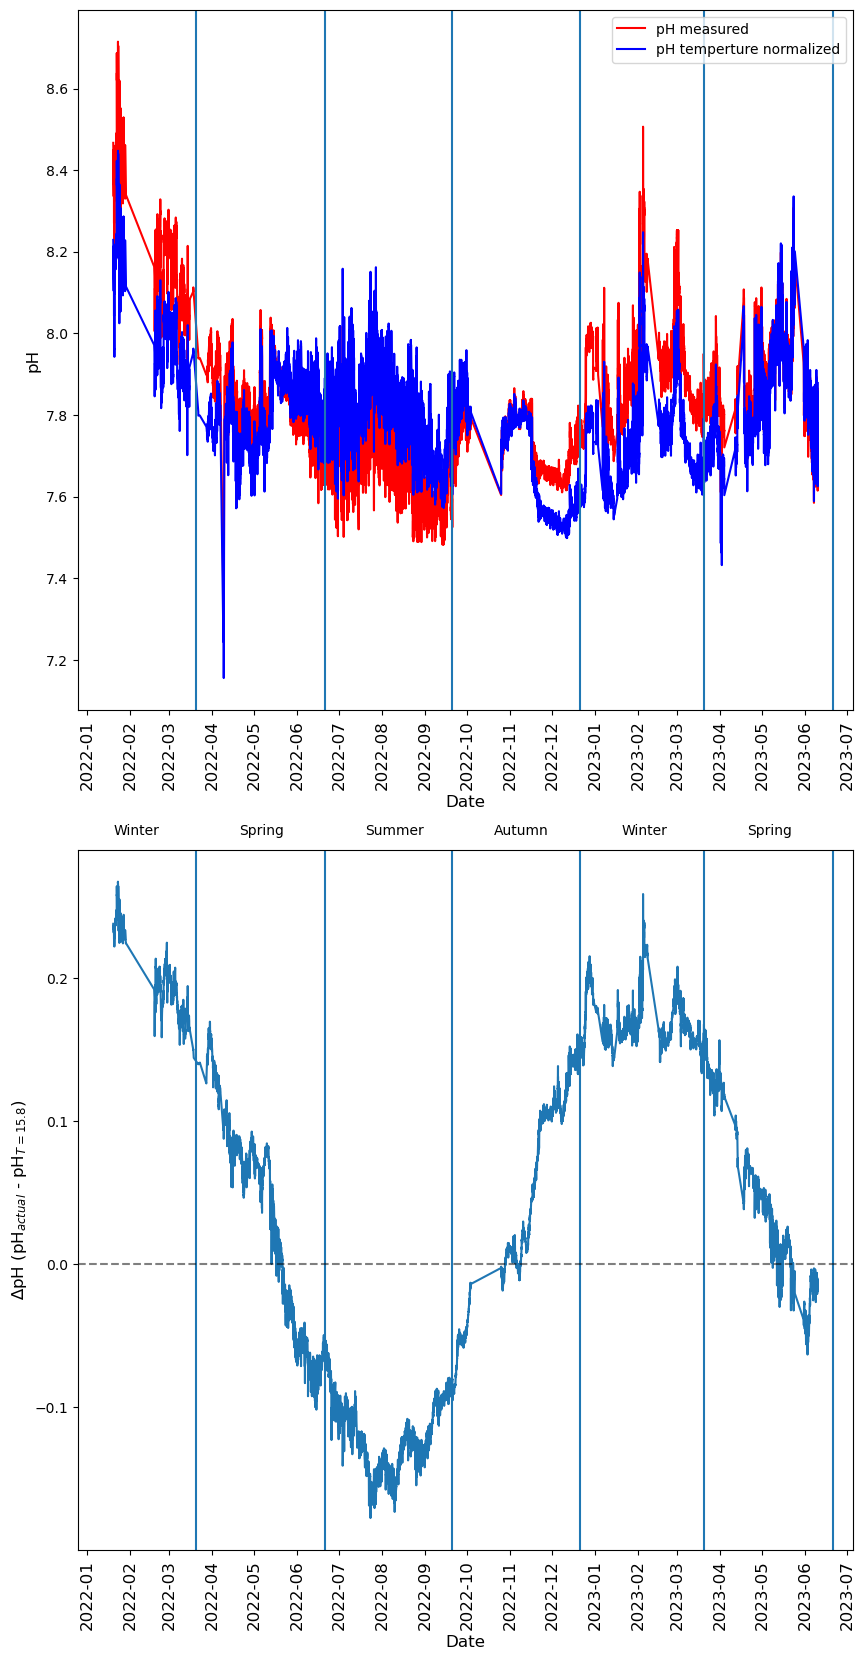

In [111]:
fig, ax = plt.subplots(nrows = 2, figsize = [10,20])

ax[0].plot(hydrocat720["DateTime"],hydrocat720['adjusted_ph temp'], color = 'red', label = 'pH measured')
ax[0].plot(hydrocat720["DateTime"],hydrocat720['pH (temperature normalized)'], color = 'blue', label = 'pH temperture normalized')
# set x-axis label
ax[0].set_xlabel("Date", fontsize = 12)
# set y-axis label
ax[0].set_ylabel("pH",fontsize=12)

ax[0].xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax[0].tick_params('x',labelsize = 12, labelrotation = 90)
ax[0].legend()

ax[0].axvline(datetime(2022, 3, 20))
ax[0].axvline(datetime(2022, 6, 21))
ax[0].axvline(datetime(2022, 9, 20))
ax[0].axvline(datetime(2022, 12, 21))
ax[0].axvline(datetime(2023, 3, 20))
ax[0].axvline(datetime(2023, 6, 21))

ax[1].plot(hydrocat720["DateTime"],hydrocat720['adjusted_ph temp']-hydrocat720['pH (temperature normalized)'])

# set x-axis label
ax[1].set_xlabel("Date", fontsize = 12)
# set y-axis label
ax[1].set_ylabel("∆pH (pH$_{actual}$ - pH$_{T = 15.8}$)",fontsize=12)
ax[1].xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax[1].tick_params('x',labelsize = 12, labelrotation = 90)
ax[1].text(datetime(2022, 1, 20), 0.3, 'Winter')
ax[1].axvline(datetime(2022, 3, 20))
ax[1].text(datetime(2022, 4, 20), 0.3, 'Spring')
ax[1].axvline(datetime(2022, 6, 21))
ax[1].text(datetime(2022, 7, 20), 0.3, 'Summer')
ax[1].axvline(datetime(2022, 9, 20))
ax[1].text(datetime(2022, 10, 20), 0.3, 'Autumn')
ax[1].axvline(datetime(2022, 12, 21))
ax[1].text(datetime(2023, 1, 20), 0.3, 'Winter')
ax[1].axvline(datetime(2023, 3, 20))
ax[1].text(datetime(2023, 4, 20), 0.3, 'Spring')
ax[1].axvline(datetime(2023, 6, 21))
ax[1].axhline(y=0.0, color='k', linestyle='dashed', alpha = 0.5)

## Observations on the effect of temperature

Based on ∆pH, we see that cooler winter temperatures increase pH. Warmer summer temperatures decrease pH.